In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools

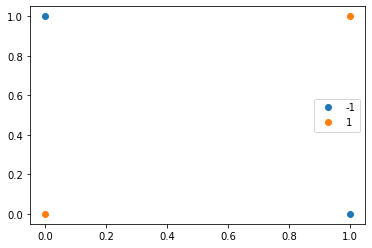

In [2]:
# a) Visualization


samples = pd.DataFrame({
    'x': [1, 0, 1, 0],
    'y': [1, 0, 0, 1],
    'label': [1, 1, -1, -1]
})
for name, group in samples.groupby('label'):
    plt.plot(group['x'], group['y'], marker="o", linestyle="",label=name)

plt.legend()



# b) Network implementation

I chose a two layer fully connected network with no hidden layers. I believe this is the simplest model that can still learn XOR. 

I am using relu as my activation function, and mean squared error loss.


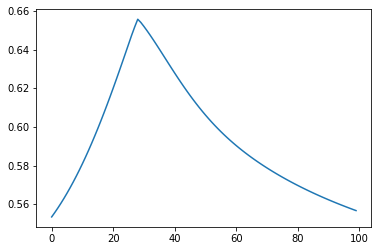

In [123]:

# b) Network implementation
# I chose a three layer fully connected network with one hidden layer and mean squared error loss. 
np.random.seed(42)

# activation functions
def relu(x):
    return max(0, x)
def d_relu(x):
    return max(0, min(x, 1))    
def tanh(x):
    return math.tanh(x)
def d_tanh(x):
    return 1 - tanh(x) ** 2
def loss(exp_y, act_y):
    return .5 * (exp_y - act_y) ** 2


# model
class Neuron:

    def __init__(self, activation_fn=relu):
        self.weights = np.random.rand(3)        
        self.weights = np.array([1, -1, .5])
        self.activation_fn = activation_fn

    def pred(self, x, output_pre=False):
        pre_activation = self.weights @ self.concat(x)
        if output_pre:
            return pre_activation
        return self.activation_fn(pre_activation)
    
    def update(self, partials, lr):
        # print(partials)
        self.weights = self.weights - partials * lr
    
    @staticmethod
    def concat(x):
        return np.concatenate((x, [1]))


class NumpyModel:    
    def  __init__(self, lr=.1):
        self.input_layer = [Neuron(), Neuron()]
        self.input_layer[0].weights = np.array([1, -1, -.5])
        self.output_layer = Neuron(activation_fn=tanh)
        self.lr = lr
    
    def pred(self, x):
        return self.output_layer.pred([self.input_layer[0].pred(x), self.input_layer[1].pred(x)])
    
    def update(self, exp_y, act_y, x):
        # Update output neuron         
        il = self.input_layer
        partial_l_output_layer = (exp_y - act_y) * d_tanh(exp_y) * np.array([il[0].pred(x), il[1].pred(x), 1])

        # Update input neuron 
        def update_input_layer(index, neuron):                      
            pre = il[index].pred(x, output_pre=True)
            neuron.update((exp_y - act_y) * d_tanh(exp_y) * d_relu(pre) * Neuron.concat(x), self.lr)

        update_input_layer(0, self.input_layer[0])
        update_input_layer(1, self.input_layer[1])      

        self.output_layer.update(partial_l_output_layer, self.lr)
        # print('o', self.output_layer.weights)


  


# Train with stochastic gradient descent
def sgd(model, train_x, train_y):    
    y_preds = []


    # print('starting new epoch')
    for x, y in zip(train_x, train_y):        
        # print('Correct ans:', y)
        prediction = model.pred(x)      
        # print('Before update:', model.pred(x))
        # print(model.input_layer[0].weights)
        # print(model.input_layer[1].weights)
        # print(model.output_layer.weights)
        y_preds.append(prediction)
        # print('After update:', model.pred(x))
        # print(model.input_layer[0].weights)
        # print(model.input_layer[1].weights)
        # print(model.output_layer.weights)
        # print()   
        
    # do the updates    
    for i in range(len(train_x)):
        model.update(y_preds[i], train_y[i], train_x[i])
            

def test(model, test_x, test_y, verbose=False):
    exp_y = [model.pred(x) for x in test_x]  
    if verbose:
        print(test_x)        
        print(test_y, exp_y)  
    return np.mean(loss(exp_y, test_y))


def train(model, epochs=10):
    history = []    
    for epoch in range(epochs):
        loss = test(model, train_x, train_y)
        history.append(loss)
        sgd(model, train_x, train_y)
    return history



train_x = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

train_y = np.array([1, -1, -1, 1])
m = NumpyModel(.01)
history = train(m, epochs=100)
plt.plot(history)

In [114]:
history[-10:]

[0.6568626711118766,
 0.6572466515273705,
 0.6625864901780223,
 0.6499358267535961,
 0.6671160960693142,
 0.6430327004045262,
 0.670388689054402,
 0.6370330843873688,
 0.6725472207830834,
 0.632161737308061]

In [115]:
# 0 ([1, -1, -.5])
# 1 ([1, -1, .5])

# il = m.input_layer
# il[0].pred([1, 0])
ol = m.output_layer
ol.weights

array([ 0.75000006,  0.29402908, -0.00403526])

In [116]:
test(m, train_x, train_y, verbose=True)

[[0 0]
 [0 1]
 [1 0]
 [1 1]]
[ 1 -1 -1  1] [0.46060276456846877, 0.22625910571182886, 0.8872826431150586, 0.8148083487902391]


0.673849061826689